In [19]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [20]:
!pip install torchinfo

In [21]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [22]:
#Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Get Data

In [23]:
import os
import zipfile

from pathlib import Path
import requests

#Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# #If the image folder doesnt exist, download it and prepare it
# if image_path.is_dir():
#     print(f"{image_path} directory exists, skipping re-download.")
# else:
print(f"Did not find {image_path}, downloading it...")
image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

#unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "a") as zip_ref:
    print("Unzipping pizza steak sushi")
    zip_ref.extractall(image_path)

os.remove(data_path/"pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza steak sushi


In [24]:
#Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Create Datasets and DataLoaders

### 2.1 creating a tranform for torchvision.models

In [25]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229,0.224,0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [26]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d3b0ee15f10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for 'torchvision.models' (auto creation)

In [27]:
import torchvision


In [28]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [29]:
#Get the transforms to create
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [30]:
#Create dataloaders using auto transforms
train_dataloader, test_dataloader, class_names  = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d3b0c41f110>,
 ['pizza', 'steak', 'sushi'])

# Getting a Pretrained Model

In [31]:
!pip install torchinfo

In [32]:
# Instance of pretrain effnet B0

import torchvision
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [33]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [34]:
from torchinfo import summary
summary(model=model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]
        )


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [35]:
## 3.4 Freezing the base model and changing the output layer to suit our needs

for param in model.features.parameters():
    param.requires_grad = False



In [36]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [37]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=3))


model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [38]:
from torchinfo import summary
summary(model=model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]
        )


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Train Model

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)



In [ ]:
from going_modular.going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total Training Time: {end_time-start_time}")


In [ ]:
try:
    from helper_functions import plot_loss_curves
    print("Failed")
except:
    print(f"[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        try:
            request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
            f.write(request.content)
        except Exception as e:
            print(f"[INFO] Failed to download the helper function {e}")

from helper_functions import plot_loss_curves

plot_loss_curves(results)


# Creating Testing function

In [61]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names: List[str],
                        image_size:Tuple[int,int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229,0.224,0.225])
        ])

    # Predict on image
    model.to(device)

    #Turn on inference mode
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim =1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs}")
    plt.axis(False)





In [65]:
# Get a random list of image paths from test set

import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg')]

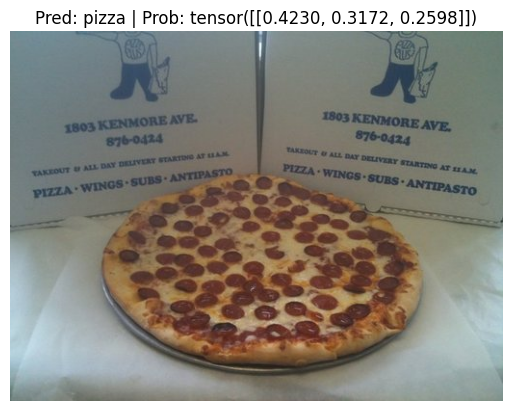

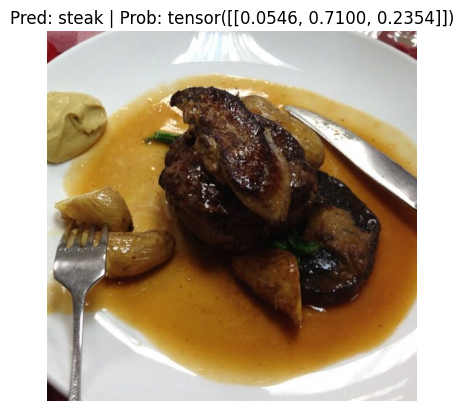

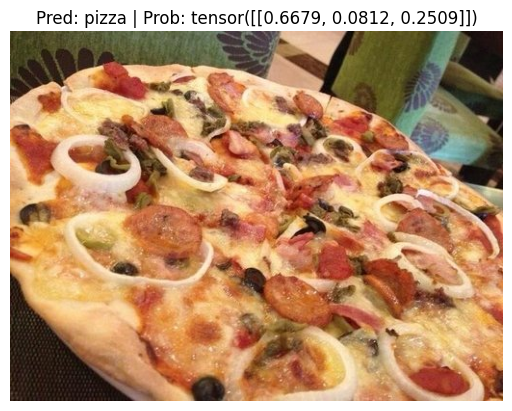

In [66]:
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names = class_names,
                        image_size=(224,224))


In [67]:
# Making predictions on a custom image

In [69]:
import requests
request = requests.get("https://assets.surlatable.com/m/15a89c2d9c6c1345/72_dpi_webp-REC-283110_Pizza.jpg")

with open("pizzaimage.jpg", "wb") as f:
    f.write(request.content)


In [ ]:
# if not "pizzaimage.jpg".is_file():
#     with open()

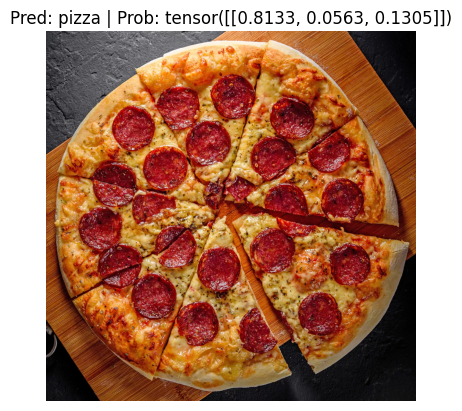

In [70]:
    pred_and_plot_image(model=model,
                        image_path="pizzaimage.jpg",
                        class_names = class_names,
                        image_size=(224,224))
